# Simulations 

> Comparison of operation modes on the local network

In [1]:
#| default_exp multi

In [2]:
#| export
from fastcore.utils import *
import pandas as pd
from cylinder.hwc_2node import HWC
from cylinder.demand import *
from cylinder.power import *
from cylinder.utils import *
import pandas as pd	
import numpy as np
import matplotlib.pyplot as plt
import random
from pathlib import Path
from collections import defaultdict
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [3]:
#| export
#| hide
@patch
def _thermostat(self:HWC):
    "Thermostat state change"
    # Nodal cylinder thermostat
    self.thermostat[0] = 0 if self.temperatures[1] > self.T_set else self.thermostat[0] # Turn off if T > T_set
    self.thermostat[0] = 1 if self.temperatures[1] < self.T_set- self.T_deadband else self.thermostat[0] # Turn on the element
    # Nodal cylinder thermostat
    self.thermostat[1] = 0 if self.temperatures[1] > self.T_set_bu else self.thermostat[1] # Turn off if T > T_set
    self.thermostat[1] = 1 if self.temperatures[1] < self.T_set_bu- self.T_deadband else self.thermostat[1] # Turn on the element
    if self.high_only: self.thermostat[1] = 0
    return self.thermostat

Want to look at some parameters around the cylinder profile and control philosophy to see the impact of these on three aspects:

* The local network lines demand - particularly at peak times where the lines face constraints
* The cost of power to service the demand

## Assumptions

In order to have reasonable comparisons over different operating scenarios we will use the draw profile of a specific 4 bedroom unit from a historical hot water usage dataset.

## Base Case

The base installation is a typical 180L hot water cylinder in a 4 bedroom houshold

In [4]:
strategy = {'name': 'Baseline: ~180L 3kW cylinder operating at 60 degrees C under thermotstat control with ripple control power supply',
            # 'operation': 'network+',
            'operation': 'continuous',
            'element' :3,
            'Tset_H' : 60.0,
            'Tset_L' : 60.0,
            'radius' : 0.22,
            'height' : 1.1,
            'ripple' : True,
            'high_only': False,
            'mixed' : False}

In [5]:
import asyncio
async def simulation(i, hwc, strategy, df_flow, power, time_period):
    temp = []
    # go through each time step and each hwc in the cluster
    for row in power.loc[time_period].itertuples(): # go through a set time period
        action = 0
        element = 0 # heating power
        # print(strategy)
        # adjust for temperature
        hwc._thermostat()
        # establish if there is power going to the element based on the thermostat state and the strategy in relation to ripple control
        if hwc.thermostat[0] == 1: # if the thermostat high temperature sensor is on then need to look to the control strategy
            if strategy['operation'] == 'off_peak': # if the strategy is to use the thermostat high temperature sensor then the element is on
                action = ~row.peak
                element = 2 if action == 1 else 0
            elif strategy['operation'] == 'continuous': # if the strategy is to use the thermostat high temperature sensor then the element is on
                action = 1
                element = 2 if action == 1 else 0

            elif strategy['operation'] == 'price': # if the strategy is to use the thermostat high temperature sensor then the element is on
                # action = 1 if row.cost < 0.1 else 0
                action = 1 if row.costrank_4h < 0.25 else 0
                element = 2 if action == 1 else 0
            elif strategy['operation'] == 'network+': # if the strategy is to use the thermostat high temperature sensor then the element is on
                # action = 1 if row.cost < 0.1 else 0
                action = 1 if row.pre_peak and row.costrank_4h < 0.5 else 0
                action = 1 if not row.peak and row.costrank_4h < 0.25 else 0
                element = 2 if action == 1 else 0

        if hwc.thermostat[1] == 1: # if the thermostat base temperature sensor is on then the element is on
            action = 1
            element = 1


        if (strategy['ripple']) & (row.ripple_control): # if ripple control is on then override the thermostat state
            action = 0
            element = 3
        # print(action, flow.loc[row.Index]*60)
        flow = df_flow.loc[row.Index, f'{hwc.unit}_{hwc.bedrooms}']*60
        hwc._update_model(action = action , flow = flow)
        temp.append([row.Index,
                    i, 
                    strategy['operation'],
                    action,
                    row.ripple_control * strategy['ripple'] ,
                    *hwc.thermostat.copy(),
                    *hwc.temperatures.copy(),
                    hwc.z,
                    flow,
                    hwc.volume,
                    hwc.bedrooms,
                    hwc.unit,
                    element])
    tmp = pd.DataFrame(temp, 
                      columns=['timestamp',
                      'id',
                            'strategy',
                            'action',
                            'ripple_control_demand',
                            'thermostat_high',
                            'thermostat_base',
                            'T0',
                            'T1',
                            'z',
                            'flow',
                            'volume',
                            'bedrooms',
                            'unit',
                            'element_power'])
    return tmp#.set_index('timestamp')

async def main(cluster_size, strategy, time_period):
    df_flow = pd.concat([load_demand(path = Path('../data/drawprofiles'), bed=rooms , unit=unit).loc[:,'flow'].to_frame().rename(columns={'flow':f'{unit}_{rooms}'}) for rooms in range(1,6) for unit in range(10)], axis=1)
    df_power = load_power(path = Path('../data/'), ripple_control=True) 
    hwcs = [HWC(T_set=strategy['Tset_H'], 
            radius=strategy['radius'],
            height=strategy['height'],
            element=strategy['element'],
            high_only=strategy['high_only'],
            U=.8,
            K=.05,
            noisey=False,
            bedrooms = random.choice(list(range(1,5))),
            unit=random.choice(list(range(1,10)))) for i in range(cluster_size)]
    res = await asyncio.gather(*[simulation(i, hwc, strategy, df_flow, df_power, time_period) for i, hwc in enumerate(hwcs)]) 
    return  pd.concat(res).set_index('timestamp').merge(df_power.loc[time_period], left_index=True, right_index=True, how='left')


In [8]:
res = await main(cluster_size=21, strategy = strategy , time_period='2020-06')
res.head()

,id,strategy,action,ripple_control_demand,thermostat_high,thermostat_base,T0,T1,z,flow,...,hour,day,peak,tou,cost,pre_peak,costrank_4h,costrank_6h,costrank_8h,costrank_12h
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-06-01,0,continuous,1,0,1,1,58.987682,56.881135,0.7,0.0,...,0,0,False,0.020004,0.032318,False,0.004166,0.002777,0.002083,0.001389
2020-06-01,1,continuous,1,0,1,1,58.987682,56.881135,0.7,0.0,...,0,0,False,0.020004,0.032318,False,0.004166,0.002777,0.002083,0.001389
2020-06-01,2,continuous,1,0,1,1,58.987682,56.881135,0.7,0.0,...,0,0,False,0.020004,0.032318,False,0.004166,0.002777,0.002083,0.001389
2020-06-01,3,continuous,1,0,1,1,58.987682,56.881135,0.7,0.0,...,0,0,False,0.020004,0.032318,False,0.004166,0.002777,0.002083,0.001389
2020-06-01,4,continuous,1,0,1,1,58.987682,56.881135,0.7,0.0,...,0,0,False,0.020004,0.032318,False,0.004166,0.002777,0.002083,0.001389


In [50]:
df =res['2020-06-08':'2020-06-08']
df = df.assign(T_mean = lambda df: df.T0*df.z + df.T1*(1-df.z),
            energy = lambda df: df.volume.mean()*4.2*((df.T0*df.z + df.T1*(1-df.z))-55)
    )

<AxesSubplot: xlabel='timestamp'>

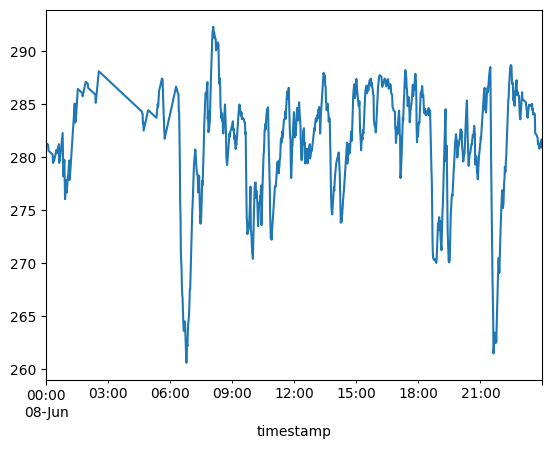

In [51]:
df.groupby('timestamp').energy.sum().plot()

Text(0.5, 0.98, 'Simulation:Baseline: ~180L 3kW cylinder operating at 60 degrees C under thermotstat control with ripple control power supply\nmode : continuous | ripple : True')

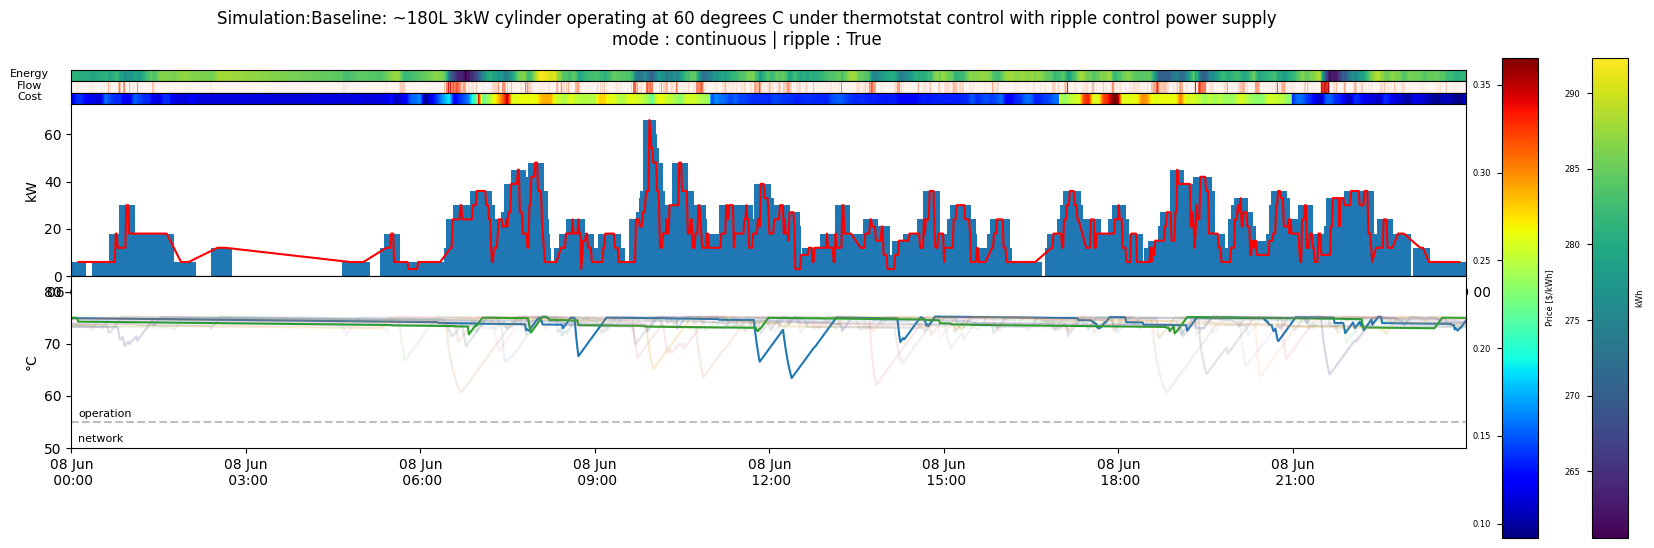

In [52]:

boost_color = 'tab:orange'
network_color = 'tab:green'
network_rc = 'tab:brown'
network_color = 'tab:green'
fig, ax = plt.subplots(nrows=5,figsize=(18,6), sharey="row", gridspec_kw=dict(height_ratios=[.2,.2,.2,3,3], hspace=0))

im2 = ax[0].imshow(df.groupby('timestamp').energy.sum().values[np.newaxis,:], cmap="viridis", aspect="auto")
ax[0].set_ylabel('Energy', rotation=0, fontsize=8)

ax[1].imshow(df.groupby('timestamp').flow.sum().values[np.newaxis,:], cmap="Reds", aspect="auto")
ax[1].set_ylabel('Flow', rotation=0, fontsize=8)

im = ax[2].imshow(df.groupby('timestamp').cost.mean().values[np.newaxis,:], cmap="jet", aspect="auto")
ax[2].set_ylabel('Cost', rotation=0, fontsize=8)

for i in range(3):
    ax[i].yaxis.set_label_coords(-0.03,.2)
    ax[i].set_yticks([])
    ax[i].set_xticks([])

# add title
title = f'Simulation:'+ strategy['name'] + '\n' +\
        'mode : ' + strategy['operation'] + ' | ' +\
        'ripple : ' + str(strategy['ripple'])


i=3
# ax[i].hist(df[df.element_power>0].groupby('timestamp').element_power.sum(), label=f'T{j}')
ax[i].bar(df[df.element_power>0].groupby('timestamp').element_power.sum().index, 3*df[df.element_power>0].groupby('timestamp').element_power.sum().values,width=0.01 )
ax[i].plot( 3*df[df.element_power>0].groupby('timestamp').element_power.sum(), color = 'red')
# ax[i].plot( df[df.element_power>0].groupby('timestamp').element_power.sum(), color = 'red', ls=':')


ax[i].set_ylabel('kW', rotation=90)
ax[i].set_ylim(0,1.1*(3*max(df[df.element_power>0].groupby('timestamp').element_power.sum())))
ax[i].margins(x=0, y=0)

i=4
for j in df.id.unique():
    ax[i].plot(df[df.id==j].T_mean, label=f'T{j}', alpha=1 if j % 12 == 0 else .1)
# ax[i].plot(df.groupby('id').T_mean)
ax[i].set_ylim(50,83)

ax[i].set_ylabel('°C', rotation=90)
ax[i].margins(x=0, y=0)
ax[i].axhline(y=55, color='grey', linestyle='--', alpha = .5)

# for k in series_timestamps((df.thermostat_base == 1)&(df.ripple_control)&(strategy['ripple'])): ax[i].axvspan(k[0], k[1], 0.08, .13, color=network_rc, alpha=0.5, hatch ='\\', ec='black') # wants power but ripple control is on
# for k in series_timestamps((df.element_power == 3)&(df.ripple_control)&(~strategy['ripple'])): ax[i].axvspan(k[0], k[1], 0.08, .13, color='blue', alpha=0.5) # wants power but ripple control is on

# # show the actual power usage
# for k in series_timestamps((df.element_power == 1)): ax[i].axvspan(k[0], k[1], 0.08, .13, color=network_color, alpha=0.5)
# for k in series_timestamps((df.element_power == 2)): ax[i].axvspan(k[0], k[1],  0.08, .13,color=boost_color, alpha=0.5)


# operation_legend = [Patch(facecolor=network_rc, hatch ='\\', ec='black', alpha=0.5 , label='Demand / No Power'),
#                     Patch(facecolor='blue', alpha=0.5 ,  label='Operation during Ripple Control'),
#                     Patch(facecolor=boost_color, alpha=0.5 ,  label='Boost Operation'),
#                     Patch(facecolor=network_color, alpha=0.5 ,   label='Base Operation')]

# show the network status

# for k in series_timestamps((df.ripple_control)): ax[i].axvspan(k[0], k[1], 0, .05, color=network_rc, alpha=0.5) # wants power but ripple control is on
# for k in series_timestamps((df.peak)): ax[i].axvspan(k[0], k[1], 0, .05, fc='none',hatch ='xx', ec='grey') # wants power but ripple control is on
# for k in series_timestamps((~df.ripple_control)): ax[i].axvspan(k[0], k[1], 0, .05, color=network_color, alpha=0.5) # wants power but ripple control is on
network_legend = [Patch(facecolor='red', alpha=0.5 , label='Ripple Control'),
                    Patch(facecolor=network_color, alpha=0.5 ,  label='Normal Operation'),
                    Patch(facecolor='none', hatch='xx', ec='grey', label='Peak Demand')]


# legend1 = plt.legend(handles = network_legend,loc='upper center',title="Electricity Network", bbox_to_anchor=(0.2, -0.12), fancybox=True, shadow=False, ncol=3)
# legend2 = plt.legend(handles = operation_legend,loc='upper center',title="Operation", bbox_to_anchor=(0.7,-.12), fancybox=True, shadow=False, ncol=4)
# ax[i].add_artist(legend1)
# ax[i].add_artist(legend2)

# add a colorbar for the price to the right of the plot
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel('Price [$/kWh]', rotation=90, labelpad=5, fontsize=6)
cbar_ax.yaxis.set_label_position('right')
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.yaxis.set_tick_params(pad=5)
# cbar_ax.set_ylim(0, 0.2)
cbar1_ax = fig.add_axes([0.97, 0.1, 0.02, 0.8])
fig.colorbar(im2, cax=cbar1_ax)
cbar1_ax.set_ylabel('kWh', rotation=90, labelpad=5, fontsize=6)
cbar1_ax.yaxis.set_label_position('right')
cbar1_ax.yaxis.set_ticks_position('left')
cbar1_ax.yaxis.set_tick_params(pad=5)

date_form = DateFormatter('%d %b\n %H:%M')
ax[-1].xaxis.set_major_formatter(date_form)
cbar_ax.yaxis.set_tick_params(labelsize=6)
cbar1_ax.yaxis.set_tick_params(labelsize=6)
ax[i].annotate('network', xy=(0, 0), xycoords='axes fraction',  xytext=(5, 10), textcoords='offset points', ha="left", va="top", fontsize=8)
ax[i].annotate('operation', xy=(0, 0), xycoords='axes fraction',  xytext=(5, 28), textcoords='offset points', ha="left", va="top", fontsize=8)
# add some whitespace to the bottom of the plot
# add a line at the end of each day
# if verbose:
#     complete_days = df.groupby('date').size().reset_index()
#     complete_days = pd.to_datetime(complete_days[complete_days[0]==1440].date.tolist())
#     # print(complete_days)
#     for n,k in enumerate(complete_days): 
#         e1 = df.loc[k.date().strftime('%Y-%m-%d')].loc[(df.element_power==1)].element_power.count()
#         e2 = df.loc[k.date().strftime('%Y-%m-%d')].loc[(df.element_power==2)].element_power.count()
#         e1p = df.loc[k.date().strftime('%Y-%m-%d')].loc[(df.element_power==1)&(df.peak)].element_power.count()
#         e2p = df.loc[k.date().strftime('%Y-%m-%d')].loc[(df.element_power==2)&(df.peak)].element_power.count()
#         e3 = 0
#         en_max = df.loc[k.date().strftime('%Y-%m-%d')].loc[(df.element_power==2)].energy.max()
#         en_min = df.loc[k.date().strftime('%Y-%m-%d')].loc[(df.element_power==2)].energy.min()
#         en_range = abs(en_max-en_min)

#         # print(en_range,e2,e3)
#         c = (df.loc[k.date().strftime('%Y-%m-%d')].loc[(df.element_power==2)|(df.element_power==1)].element_power * \
#             df.loc[k.date().strftime('%Y-%m-%d')].loc[(df.element_power==2)|(df.element_power==1)].cost).sum() /60*strategy['element']
#         kwh = (e1+e2)/60*strategy['element']
#         avecost = c/kwh
#         base = k + pd.Timedelta(f'1d')
#         ax[i].axvspan(base-pd.Timedelta(f'{e2}m'), base, 0.92, .95, color=boost_color, alpha=0.5, ec='black')
#         ax[i].axvspan(base-pd.Timedelta(f'{e2}m') - pd.Timedelta(f'{e1}m'), base-pd.Timedelta(f'{e2}m'), 0.92, .95, color=network_color, alpha=0.5, ec='black')
#         ax[i].annotate(f'{kwh:.1f} kWh', xy=(base- pd.Timedelta(f'{e1+e2+e3}m'), 80), xycoords='data',  xytext=(-3, 0), textcoords='offset points', ha="right", va="center", fontsize=8)
#         ax[i].annotate(f'${avecost:.2f} /kWh', xy=(base, 80), xycoords='data',  xytext=(3, 0), textcoords='offset points', ha="left", va="center", fontsize=8)
        
#         ax[i].annotate(f'{en_range:.2f} kWh', xy=(base, 82), xycoords='data',  xytext=(0, 0), textcoords='offset points', ha="right", va="center", fontsize=8)

#     for k in df.index.floor('D').unique()[1:]: ax[i].axvline(k, color='grey', alpha = .1)



fig.subplots_adjust(bottom=0.25)
fig.suptitle(title)
    # return 

Text(0.5, 0.98, 'Simulation:Baseline: ~180L 3kW cylinder operating at 60 degrees C under thermotstat control with ripple control power supply\nmode : network+ | ripple : True')

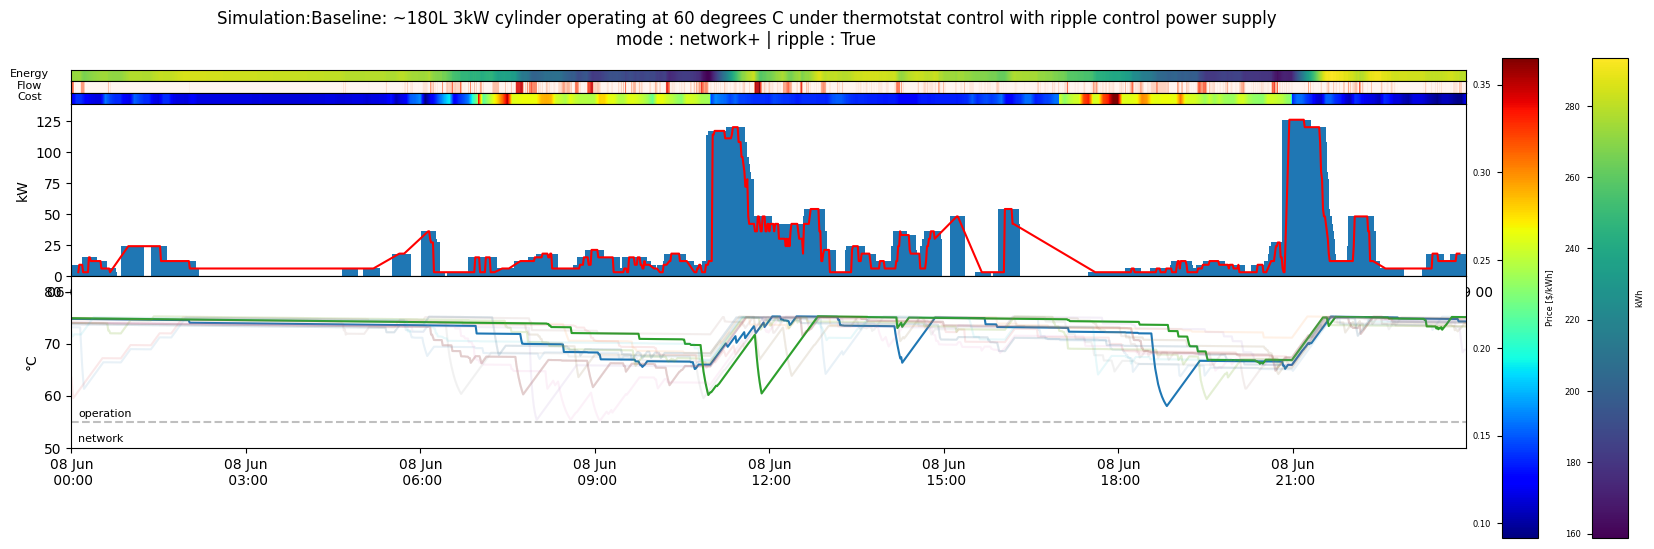

In [46]:

boost_color = 'tab:orange'
network_color = 'tab:green'
network_rc = 'tab:brown'
network_color = 'tab:green'
fig, ax = plt.subplots(nrows=5,figsize=(18,6), sharey="row", gridspec_kw=dict(height_ratios=[.2,.2,.2,3,3], hspace=0))

im2 = ax[0].imshow(df.groupby('timestamp').energy.sum().values[np.newaxis,:], cmap="viridis", aspect="auto")
ax[0].set_ylabel('Energy', rotation=0, fontsize=8)

ax[1].imshow(df.groupby('timestamp').flow.sum().values[np.newaxis,:], cmap="Reds", aspect="auto")
ax[1].set_ylabel('Flow', rotation=0, fontsize=8)

im = ax[2].imshow(df.groupby('timestamp').cost.mean().values[np.newaxis,:], cmap="jet", aspect="auto")
ax[2].set_ylabel('Cost', rotation=0, fontsize=8)

for i in range(3):
    ax[i].yaxis.set_label_coords(-0.03,.2)
    ax[i].set_yticks([])
    ax[i].set_xticks([])

# add title
title = f'Simulation:'+ strategy['name'] + '\n' +\
        'mode : ' + strategy['operation'] + ' | ' +\
        'ripple : ' + str(strategy['ripple'])


i=3
# ax[i].hist(df[df.element_power>0].groupby('timestamp').element_power.sum(), label=f'T{j}')
ax[i].bar(df[df.element_power>0].groupby('timestamp').element_power.sum().index, 3*df[df.element_power>0].groupby('timestamp').element_power.sum().values,width=0.01 )
ax[i].plot( 3*df[df.element_power>0].groupby('timestamp').element_power.sum(), color = 'red')
# ax[i].plot( df[df.element_power>0].groupby('timestamp').element_power.sum(), color = 'red', ls=':')


ax[i].set_ylabel('kW', rotation=90)
ax[i].set_ylim(0,1.1*(3*max(df[df.element_power>0].groupby('timestamp').element_power.sum())))
ax[i].margins(x=0, y=0)

i=4
for j in df.id.unique():
    ax[i].plot(df[df.id==j].T_mean, label=f'T{j}', alpha=1 if j % 12 == 0 else .1)
# ax[i].plot(df.groupby('id').T_mean)
ax[i].set_ylim(50,83)

ax[i].set_ylabel('°C', rotation=90)
ax[i].margins(x=0, y=0)
ax[i].axhline(y=55, color='grey', linestyle='--', alpha = .5)

# for k in series_timestamps((df.thermostat_base == 1)&(df.ripple_control)&(strategy['ripple'])): ax[i].axvspan(k[0], k[1], 0.08, .13, color=network_rc, alpha=0.5, hatch ='\\', ec='black') # wants power but ripple control is on
# for k in series_timestamps((df.element_power == 3)&(df.ripple_control)&(~strategy['ripple'])): ax[i].axvspan(k[0], k[1], 0.08, .13, color='blue', alpha=0.5) # wants power but ripple control is on

# # show the actual power usage
# for k in series_timestamps((df.element_power == 1)): ax[i].axvspan(k[0], k[1], 0.08, .13, color=network_color, alpha=0.5)
# for k in series_timestamps((df.element_power == 2)): ax[i].axvspan(k[0], k[1],  0.08, .13,color=boost_color, alpha=0.5)


# operation_legend = [Patch(facecolor=network_rc, hatch ='\\', ec='black', alpha=0.5 , label='Demand / No Power'),
#                     Patch(facecolor='blue', alpha=0.5 ,  label='Operation during Ripple Control'),
#                     Patch(facecolor=boost_color, alpha=0.5 ,  label='Boost Operation'),
#                     Patch(facecolor=network_color, alpha=0.5 ,   label='Base Operation')]

# show the network status

# for k in series_timestamps((df.ripple_control)): ax[i].axvspan(k[0], k[1], 0, .05, color=network_rc, alpha=0.5) # wants power but ripple control is on
# for k in series_timestamps((df.peak)): ax[i].axvspan(k[0], k[1], 0, .05, fc='none',hatch ='xx', ec='grey') # wants power but ripple control is on
# for k in series_timestamps((~df.ripple_control)): ax[i].axvspan(k[0], k[1], 0, .05, color=network_color, alpha=0.5) # wants power but ripple control is on
network_legend = [Patch(facecolor='red', alpha=0.5 , label='Ripple Control'),
                    Patch(facecolor=network_color, alpha=0.5 ,  label='Normal Operation'),
                    Patch(facecolor='none', hatch='xx', ec='grey', label='Peak Demand')]


# legend1 = plt.legend(handles = network_legend,loc='upper center',title="Electricity Network", bbox_to_anchor=(0.2, -0.12), fancybox=True, shadow=False, ncol=3)
# legend2 = plt.legend(handles = operation_legend,loc='upper center',title="Operation", bbox_to_anchor=(0.7,-.12), fancybox=True, shadow=False, ncol=4)
# ax[i].add_artist(legend1)
# ax[i].add_artist(legend2)

# add a colorbar for the price to the right of the plot
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel('Price [$/kWh]', rotation=90, labelpad=5, fontsize=6)
cbar_ax.yaxis.set_label_position('right')
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.yaxis.set_tick_params(pad=5)
# cbar_ax.set_ylim(0, 0.2)
cbar1_ax = fig.add_axes([0.97, 0.1, 0.02, 0.8])
fig.colorbar(im2, cax=cbar1_ax)
cbar1_ax.set_ylabel('kWh', rotation=90, labelpad=5, fontsize=6)
cbar1_ax.yaxis.set_label_position('right')
cbar1_ax.yaxis.set_ticks_position('left')
cbar1_ax.yaxis.set_tick_params(pad=5)

date_form = DateFormatter('%d %b\n %H:%M')
ax[-1].xaxis.set_major_formatter(date_form)
cbar_ax.yaxis.set_tick_params(labelsize=6)
cbar1_ax.yaxis.set_tick_params(labelsize=6)
ax[i].annotate('network', xy=(0, 0), xycoords='axes fraction',  xytext=(5, 10), textcoords='offset points', ha="left", va="top", fontsize=8)
ax[i].annotate('operation', xy=(0, 0), xycoords='axes fraction',  xytext=(5, 28), textcoords='offset points', ha="left", va="top", fontsize=8)
# add some whitespace to the bottom of the plot
# add a line at the end of each day
# if verbose:
#     complete_days = df.groupby('date').size().reset_index()
#     complete_days = pd.to_datetime(complete_days[complete_days[0]==1440].date.tolist())
#     # print(complete_days)
#     for n,k in enumerate(complete_days): 
#         e1 = df.loc[k.date().strftime('%Y-%m-%d')].loc[(df.element_power==1)].element_power.count()
#         e2 = df.loc[k.date().strftime('%Y-%m-%d')].loc[(df.element_power==2)].element_power.count()
#         e1p = df.loc[k.date().strftime('%Y-%m-%d')].loc[(df.element_power==1)&(df.peak)].element_power.count()
#         e2p = df.loc[k.date().strftime('%Y-%m-%d')].loc[(df.element_power==2)&(df.peak)].element_power.count()
#         e3 = 0
#         en_max = df.loc[k.date().strftime('%Y-%m-%d')].loc[(df.element_power==2)].energy.max()
#         en_min = df.loc[k.date().strftime('%Y-%m-%d')].loc[(df.element_power==2)].energy.min()
#         en_range = abs(en_max-en_min)

#         # print(en_range,e2,e3)
#         c = (df.loc[k.date().strftime('%Y-%m-%d')].loc[(df.element_power==2)|(df.element_power==1)].element_power * \
#             df.loc[k.date().strftime('%Y-%m-%d')].loc[(df.element_power==2)|(df.element_power==1)].cost).sum() /60*strategy['element']
#         kwh = (e1+e2)/60*strategy['element']
#         avecost = c/kwh
#         base = k + pd.Timedelta(f'1d')
#         ax[i].axvspan(base-pd.Timedelta(f'{e2}m'), base, 0.92, .95, color=boost_color, alpha=0.5, ec='black')
#         ax[i].axvspan(base-pd.Timedelta(f'{e2}m') - pd.Timedelta(f'{e1}m'), base-pd.Timedelta(f'{e2}m'), 0.92, .95, color=network_color, alpha=0.5, ec='black')
#         ax[i].annotate(f'{kwh:.1f} kWh', xy=(base- pd.Timedelta(f'{e1+e2+e3}m'), 80), xycoords='data',  xytext=(-3, 0), textcoords='offset points', ha="right", va="center", fontsize=8)
#         ax[i].annotate(f'${avecost:.2f} /kWh', xy=(base, 80), xycoords='data',  xytext=(3, 0), textcoords='offset points', ha="left", va="center", fontsize=8)
        
#         ax[i].annotate(f'{en_range:.2f} kWh', xy=(base, 82), xycoords='data',  xytext=(0, 0), textcoords='offset points', ha="right", va="center", fontsize=8)

#     for k in df.index.floor('D').unique()[1:]: ax[i].axvline(k, color='grey', alpha = .1)



fig.subplots_adjust(bottom=0.25)
fig.suptitle(title)
    # return 

In [ ]:
# count to 100 and make a variable true for every 10th
# if the variable is true, print the number

# for i in range(100):
#     if i % 10 == 0:


Text(0.5, 0.98, 'Simulation:Baseline: ~180L 3kW cylinder operating at 60 degrees C under thermotstat control with ripple control power supply\nmode : network+ | bedrooms : 4\nelement : 3kW | ripple : True')

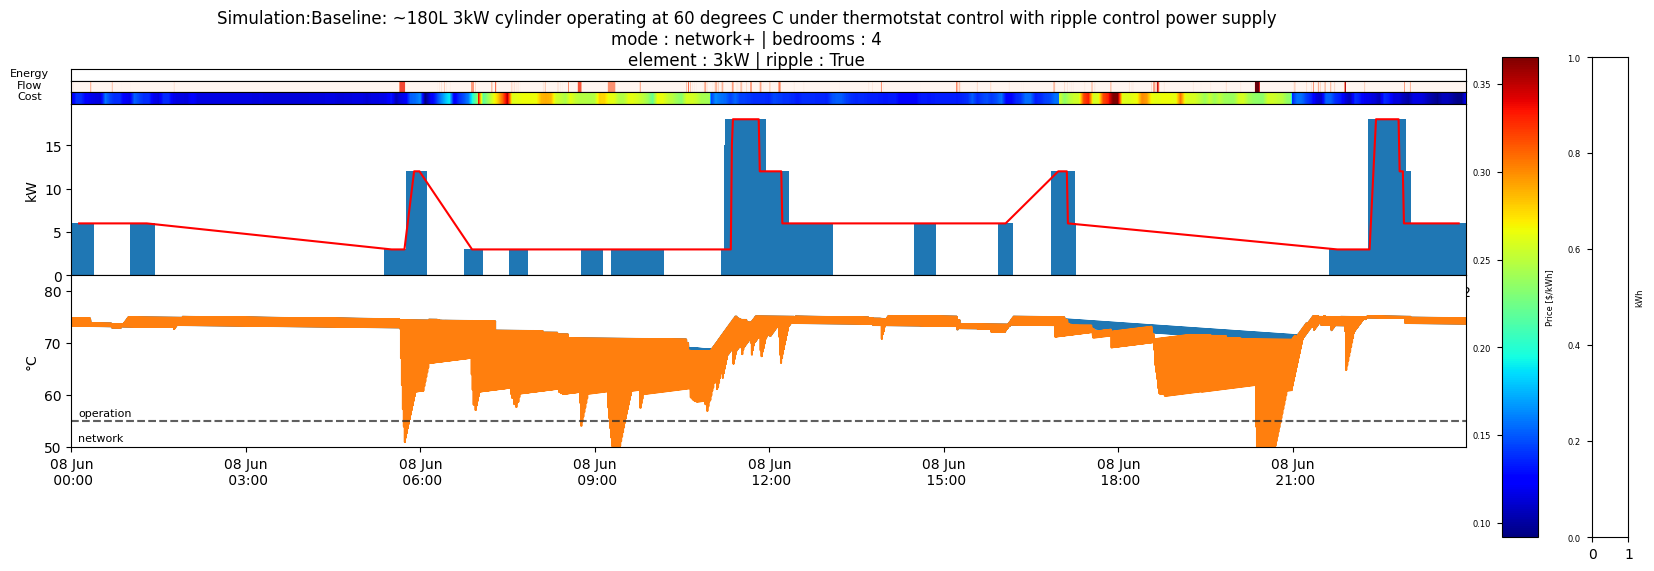

In [8]:
# def plot_multi(strategy, df, verbose=True):
boost_color = 'tab:orange'
network_color = 'tab:green'
network_rc = 'tab:brown'
network_color = 'tab:green'
fig, ax = plt.subplots(nrows=5,figsize=(18,6), sharey="row", gridspec_kw=dict(height_ratios=[.2,.2,.2,3,3], hspace=0))

# im2 = ax[0].imshow(df.energy.values[np.newaxis,:], cmap="viridis", aspect="auto", vmin=0, vmax=18)
ax[0].set_ylabel('Energy', rotation=0, fontsize=8)

ax[1].imshow(df.groupby('timestamp').flow.sum().values[np.newaxis,:], cmap="Reds", aspect="auto")
ax[1].set_ylabel('Flow', rotation=0, fontsize=8)

im = ax[2].imshow(df.groupby('timestamp').cost.mean().values[np.newaxis,:], cmap="jet", aspect="auto")
ax[2].set_ylabel('Cost', rotation=0, fontsize=8)

for i in range(3):
    ax[i].yaxis.set_label_coords(-0.03,.2)
    ax[i].set_yticks([])
    ax[i].set_xticks([])

# add title
title = f'Simulation:'+ strategy['name'] + '\n' +\
        'mode : ' + strategy['operation'] + ' | ' +\
        'bedrooms : ' + str(strategy['bedrooms']) + '\n' +\
        'element : ' + str(strategy['element']) + 'kW | ' +\
        'ripple : ' + str(strategy['ripple'])


i=3
# ax[i].hist(df[df.element_power>0].groupby('timestamp').element_power.sum(), label=f'T{j}')
ax[i].bar(df[df.element_power>0].groupby('timestamp').element_power.sum().index, 3*df[df.element_power>0].groupby('timestamp').element_power.sum().values,width=0.01 )
ax[i].plot( 3*df[df.element_power>0].groupby('timestamp').element_power.sum(), color = 'red')
# ax[i].plot( df[df.element_power>0].groupby('timestamp').element_power.sum(), color = 'red', ls=':')


ax[i].set_ylabel('kW', rotation=90)
ax[i].set_ylim(0,1.1*(3*max(df[df.element_power>0].groupby('timestamp').element_power.sum())))
ax[i].margins(x=0, y=0)

i=4
for j in range(2):
    ax[i].plot(df[f'T{j}'], label=f'T{j}')
ax[i].set_ylim(50,83)

ax[i].set_ylabel('°C', rotation=90)
ax[i].margins(x=0, y=0)
ax[i].axhline(y=55, color='grey', linestyle='--', alpha = .5)

# for k in series_timestamps((df.thermostat_base == 1)&(df.ripple_control)&(strategy['ripple'])): ax[i].axvspan(k[0], k[1], 0.08, .13, color=network_rc, alpha=0.5, hatch ='\\', ec='black') # wants power but ripple control is on
# for k in series_timestamps((df.element_power == 3)&(df.ripple_control)&(~strategy['ripple'])): ax[i].axvspan(k[0], k[1], 0.08, .13, color='blue', alpha=0.5) # wants power but ripple control is on

# # show the actual power usage
# for k in series_timestamps((df.element_power == 1)): ax[i].axvspan(k[0], k[1], 0.08, .13, color=network_color, alpha=0.5)
# for k in series_timestamps((df.element_power == 2)): ax[i].axvspan(k[0], k[1],  0.08, .13,color=boost_color, alpha=0.5)


# operation_legend = [Patch(facecolor=network_rc, hatch ='\\', ec='black', alpha=0.5 , label='Demand / No Power'),
#                     Patch(facecolor='blue', alpha=0.5 ,  label='Operation during Ripple Control'),
#                     Patch(facecolor=boost_color, alpha=0.5 ,  label='Boost Operation'),
#                     Patch(facecolor=network_color, alpha=0.5 ,   label='Base Operation')]

ax[i].axhline(y=55, color='k', linestyle='--', alpha = .5)
# show the network status

# for k in series_timestamps((df.ripple_control)): ax[i].axvspan(k[0], k[1], 0, .05, color=network_rc, alpha=0.5) # wants power but ripple control is on
# for k in series_timestamps((df.peak)): ax[i].axvspan(k[0], k[1], 0, .05, fc='none',hatch ='xx', ec='grey') # wants power but ripple control is on
# for k in series_timestamps((~df.ripple_control)): ax[i].axvspan(k[0], k[1], 0, .05, color=network_color, alpha=0.5) # wants power but ripple control is on
network_legend = [Patch(facecolor='red', alpha=0.5 , label='Ripple Control'),
                    Patch(facecolor=network_color, alpha=0.5 ,  label='Normal Operation'),
                    Patch(facecolor='none', hatch='xx', ec='grey', label='Peak Demand')]


# legend1 = plt.legend(handles = network_legend,loc='upper center',title="Electricity Network", bbox_to_anchor=(0.2, -0.12), fancybox=True, shadow=False, ncol=3)
# legend2 = plt.legend(handles = operation_legend,loc='upper center',title="Operation", bbox_to_anchor=(0.7,-.12), fancybox=True, shadow=False, ncol=4)
# ax[i].add_artist(legend1)
# ax[i].add_artist(legend2)

# add a colorbar for the price to the right of the plot
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel('Price [$/kWh]', rotation=90, labelpad=5, fontsize=6)
cbar_ax.yaxis.set_label_position('right')
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.yaxis.set_tick_params(pad=5)
# cbar_ax.set_ylim(0, 0.2)
cbar1_ax = fig.add_axes([0.97, 0.1, 0.02, 0.8])
# fig.colorbar(im2, cax=cbar1_ax)
cbar1_ax.set_ylabel('kWh', rotation=90, labelpad=5, fontsize=6)
cbar1_ax.yaxis.set_label_position('right')
cbar1_ax.yaxis.set_ticks_position('left')
cbar1_ax.yaxis.set_tick_params(pad=5)

date_form = DateFormatter('%d %b\n %H:%M')
ax[-1].xaxis.set_major_formatter(date_form)
cbar_ax.yaxis.set_tick_params(labelsize=6)
cbar1_ax.yaxis.set_tick_params(labelsize=6)
ax[i].annotate('network', xy=(0, 0), xycoords='axes fraction',  xytext=(5, 10), textcoords='offset points', ha="left", va="top", fontsize=8)
ax[i].annotate('operation', xy=(0, 0), xycoords='axes fraction',  xytext=(5, 28), textcoords='offset points', ha="left", va="top", fontsize=8)
# add some whitespace to the bottom of the plot
# add a line at the end of each day
# if verbose:
#     complete_days = df.groupby('date').size().reset_index()
#     complete_days = pd.to_datetime(complete_days[complete_days[0]==1440].date.tolist())
#     # print(complete_days)
#     for n,k in enumerate(complete_days): 
#         e1 = df.loc[k.date().strftime('%Y-%m-%d')].loc[(df.element_power==1)].element_power.count()
#         e2 = df.loc[k.date().strftime('%Y-%m-%d')].loc[(df.element_power==2)].element_power.count()
#         e1p = df.loc[k.date().strftime('%Y-%m-%d')].loc[(df.element_power==1)&(df.peak)].element_power.count()
#         e2p = df.loc[k.date().strftime('%Y-%m-%d')].loc[(df.element_power==2)&(df.peak)].element_power.count()
#         e3 = 0
#         en_max = df.loc[k.date().strftime('%Y-%m-%d')].loc[(df.element_power==2)].energy.max()
#         en_min = df.loc[k.date().strftime('%Y-%m-%d')].loc[(df.element_power==2)].energy.min()
#         en_range = abs(en_max-en_min)

#         # print(en_range,e2,e3)
#         c = (df.loc[k.date().strftime('%Y-%m-%d')].loc[(df.element_power==2)|(df.element_power==1)].element_power * \
#             df.loc[k.date().strftime('%Y-%m-%d')].loc[(df.element_power==2)|(df.element_power==1)].cost).sum() /60*strategy['element']
#         kwh = (e1+e2)/60*strategy['element']
#         avecost = c/kwh
#         base = k + pd.Timedelta(f'1d')
#         ax[i].axvspan(base-pd.Timedelta(f'{e2}m'), base, 0.92, .95, color=boost_color, alpha=0.5, ec='black')
#         ax[i].axvspan(base-pd.Timedelta(f'{e2}m') - pd.Timedelta(f'{e1}m'), base-pd.Timedelta(f'{e2}m'), 0.92, .95, color=network_color, alpha=0.5, ec='black')
#         ax[i].annotate(f'{kwh:.1f} kWh', xy=(base- pd.Timedelta(f'{e1+e2+e3}m'), 80), xycoords='data',  xytext=(-3, 0), textcoords='offset points', ha="right", va="center", fontsize=8)
#         ax[i].annotate(f'${avecost:.2f} /kWh', xy=(base, 80), xycoords='data',  xytext=(3, 0), textcoords='offset points', ha="left", va="center", fontsize=8)
        
#         ax[i].annotate(f'{en_range:.2f} kWh', xy=(base, 82), xycoords='data',  xytext=(0, 0), textcoords='offset points', ha="right", va="center", fontsize=8)

#     for k in df.index.floor('D').unique()[1:]: ax[i].axvline(k, color='grey', alpha = .1)



fig.subplots_adjust(bottom=0.25)
fig.suptitle(title)
    # return 

<BarContainer object of 285 artists>

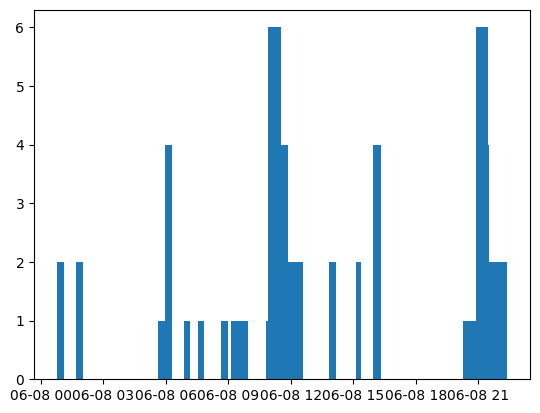

In [9]:
plt.bar(df[df.element_power>0].groupby('timestamp').element_power.sum().index, df[df.element_power>0].groupby('timestamp').element_power.sum().values,width=0.01 )

In [10]:
df.id.unique()

array([0, 1, 2])

# Compare Simultions 

In [11]:
#| hide
data = []
days = df[0].index.floor('D').unique().shape
for n, sim in enumerate(df):
    t_mean = (0.7*df[n].T0.mean()+ 0.3*df[n].T1.mean())
    peak_demand = (df[n].peak*strategies[n]["element"]*df[n].action).sum()/len(df[n])
    # print(f'demand at peak : {100*peak_demand:.2f}%')
    local_kwh = df[n].loc[df[n].element_power==1].element_power.count()*strategies[n]["element"]/60
    remote_kwh = df[n].loc[df[n].element_power==2].element_power.count()*strategies[n]["element"]/60
    total_kwh = local_kwh+remote_kwh
    # print(f'Local kWh : {local_kwh:.2f}',end=' ')
    # print(f'Remote kWh : {remote_kwh:.2f}')
    local_cost = (df[n].cost*strategies[n]["element"]/60*df[n].action*df[n].thermostat_base).sum()
    remote_cost = (df[n].cost*strategies[n]["element"]/60*df[n].action*df[n].thermostat_high*(df[n].thermostat_base!=1)).sum()
    # print(f'Local Cost : {local_cost/local_kwh:.2f}',end=' ')
    # print(f'Remote Cost : {remote_cost/remote_kwh:.2f}')

    loss_of_service = (df[n].T0<55).sum()
    days = (df[0].iloc[-1].name-df[0].iloc[0].name).days
    # print(f'Days : {days:.2f}')    
    # print(f'Loss of Service : {100*loss_of_service:.2f}%')    
    data.append([*strategies[n].values(),
                 df[n].iloc[0].name,
                 df[n].iloc[-1].name,
                 df[n].volume.mean()*1000,
                 peak_demand,
                 local_kwh,
                 remote_kwh,
                 local_kwh+remote_kwh,
                 local_cost,
                 remote_cost,
                 local_cost+remote_cost,
                 t_mean,
                 loss_of_service])
summary = pd.DataFrame(data,columns=list(strategies[0].keys())+['start_time', 'end_time', 'volume','peak_demand', 'local_kwh', 'remote_kwh', 'total_kwh', 'local_cost', 'remote_cost', 'total_cost', 't_mean', 'loss_of_service'])
summary['peak_reduction'] = 100*(summary.peak_demand-summary.loc[0,'peak_demand'])/summary.loc[0,'peak_demand']
summary['cost_reduction'] = 100*(summary.total_cost-summary.loc[0,'total_cost'])/summary.loc[0,'total_cost']
summary['daily_kWh'] = summary.total_kwh/days



KeyError: 0

In [ ]:
summary.T

,0,1,2,3
name,Baseline: ~180L 3kW cylinder operating at 60 d...,Baseline case: current operation with no rippl...,Split Control: remote operation on price signa...,Split Control: remote operation on price signa...
operation,continuous,off_peak,price,network+
bedrooms,4,4,4,4
element,3,3,3,3
Tset_H,60.0,60.0,75.0,75.0
Tset_L,60.0,60.0,60.0,60.0
radius,0.22,0.22,0.22,0.25
height,1.1,1.1,1.1,1.1
ripple,True,False,False,True
high_only,False,False,True,False


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()